# LSTM model full hour

Libraries import

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import numpy as np
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import load_model


from sklearn.metrics import mean_squared_error, mean_absolute_error

CSV file reading

In [70]:
# Read the CSV file
all_data = pd.read_csv("data_for_main_model/data_ready_for_training.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)
all_data = all_data[["relh", "skph", "temp", "minutes", "year"]]

In [71]:
all_data.head()

,relh,skph,temp,minutes,year
0,100.0,0.000,-2.0,0,2012
1,100.0,0.000,-2.0,30,2012
2,100.0,3.704,-2.0,0,2012
3,100.0,0.000,-2.0,30,2012
4,100.0,5.556,-3.0,0,2012


In [72]:
# only full hours
all_data = all_data[all_data['minutes'] == 0]
all_data.drop('minutes',axis='columns', inplace=True)

Tranformation and split data

In [73]:
# GLOBAL
training_mean = []
training_std = []

In [74]:
def standard_score(X, y, index, training_mean, training_std, timestamps_count = 0):
    X[:, :, index] = (X[:, :, index] - training_mean) / training_std
    y[:, index] = (y[:, index] - training_mean) / training_std


def transform_and_split_data(df_input, window_size = 6, test_size = 0.1,  valid_size = 0.1, timestamps_count = 0):
    df = df_input.to_numpy()
    features_len = df_input.shape[1]
    data_count = len(df)
    X = []
    y = []
    # Explanatory X and Response y variables 
    for i in range(data_count-window_size - timestamps_count):
        row = [r for r in df[i:i+window_size]]
        X.append(row)
        label = [df[i+window_size + timestamps_count]]
        y.append(label)
    X = np.array(X)
    y = np.array(y)

    resh0 = y.shape[0]
    resh1 = y.shape[2]
    y = y.reshape(resh0, resh1)
    # data split
    train_size = 1 - test_size - valid_size
    train_last_el = int(data_count * train_size)
    valid_last_el = train_last_el + int(data_count * valid_size)

    X_train, y_train = X[:train_last_el], y[:train_last_el]

    X_val, y_val = X[train_last_el:valid_last_el], y[train_last_el:valid_last_el]
    X_test, y_test = X[valid_last_el:], y[valid_last_el:]

    training_mean = []
    training_std = []
    # data normalization
    for i in range(features_len):
        training_mean.append(np.mean(X[:, :, i]))
        training_std.append(np.std(X[:, :, i]))
        standard_score(X_train, y_train, i, training_mean[i], training_std[i])
        standard_score(X_val, y_val, i, training_mean[i], training_std[i])
        standard_score(X_test, y_test, i, training_mean[i], training_std[i])

    return  X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std

LSTM model init, learn and save

In [75]:
# neural network model
def LSTM_model(X_train, y_train, X_val, y_val, epochs =10, learning_rate=0.001, window_size = 6):
    model = Sequential()
    model.add(InputLayer((window_size, 3)))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, 'ReLU')) # previous was ReLU
    model.add(Dense(3, 'linear'))
    # model = Sequential()
    # model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 3)))
    # model.add(LSTM(16, 'ReLU')) # previous was ReLU
    # model.add(Dense(32, 'ReLU')) # previous was ReLU
    # model.add(Dense(3, 'linear'))

    # cp = ModelCheckpoint('LSTM_model', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate= learning_rate), metrics=[RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size = 128)#, callbacks=[cp])
    return model

Make predicitions and plot output

In [76]:
def denormalization(y, training_mean, training_std):
  y = (y*training_std) + training_mean
  return y

def make_predictions(model, X, y,  training_mean, training_std):
  predictions = model.predict(X)
  
  features_len = y.shape[1]
  pred = []
  actual =[]

  for i in range(features_len):
    pred.append(denormalization(predictions[:,i], training_mean[i], training_std[i]))
    actual.append(denormalization(y[:,i], training_mean[i], training_std[i]))

  return pred, actual

def plot_predictions_and_actual(pred, actual, start=24, end=48):

  fig, axs = plt.subplots(4)
  fig.suptitle('Weather parameters - red means predicted')
  fig.tight_layout(pad=1.8)
  axs[0].plot(pred[0][start:end],'r')
  axs[0].plot(actual[0][start:end])
  axs[0].set_title('relative humidity')

  axs[1].plot(pred[1][start:end],'r')
  axs[1].plot(actual[1][start:end])
  axs[1].set_title('speed of wind')

  axs[2].plot(pred[2][start:end],'r')
  axs[2].plot(actual[2][start:end])
  axs[2].set_title('temperature')

  axs[3].plot(actual[2][:])
  axs[3].set_title('temperature')


MSE calculations for given window size and etc. for the next 1 to 5 hours

In [77]:
def return_time(data,window_size,test_size,valid_size,epochs,learning_rate, save_model = False):
    
    MSE_humid = []
    MAE_humid = []

    MSE_wind = []
    MAE_wind = []
    
    MSE_temp = []
    MAE_temp = []

    # MSE calculations for given window size and etc. in next 1 to 3 next hours
    # last_pred_hour == 3 means that predictions are from +1 hour till +3 hours
    last_pred_hour = 3
    for hour in range(last_pred_hour):
        # (hour == ) it means that predictions will be made for next one hour
        X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std = transform_and_split_data(data.copy(), window_size, test_size, valid_size, hour)  
        X_test.size
        model = LSTM_model(X_train, y_train, X_val, y_val, epochs, learning_rate, window_size)

        ## save as binary file .pkl
        if(save_model):
            file_name = "lstm_" + str(hour+1) + ".pkl"
            with open(file_name, "xb") as f_1:
                pickle.dump(model, f_1, -1)

        pred, actaul = make_predictions(model, X_test, y_test,  training_mean, training_std)
        MSE_humid.append(mean_squared_error(actaul[0], pred[0]))
        MAE_humid.append(mean_absolute_error(actaul[0], pred[0]))
        MSE_wind.append(mean_squared_error(actaul[1], pred[1]))
        MAE_wind.append(mean_absolute_error(actaul[1], pred[1]))
        MSE_temp.append(mean_squared_error(actaul[2], pred[2]))
        MAE_temp.append(mean_absolute_error(actaul[2], pred[2]))


    return MSE_humid, MAE_humid, MSE_wind, MAE_wind, MSE_temp, MAE_temp, pred, actaul

In [78]:
test_size = 0.15
valid_size = 0.15
epochs = 12
learning_rate=0.001

AllMAE_temp_6 = []
AllMAE_humid_6 = []
AllMAE_wind_6 = []

AllMAE_temp_12 = []
AllMAE_humid_12 = []
AllMAE_wind_12 = []

# for [12-20]; [15-20]; [18-20]
for year in range(2012,2019,3):
    

    window_size = 6
    MSE_humid_6, MAE_humid_6, MSE_wind_6, MAE_wind_6, MSE_temp_6, MAE_temp_6, pred_6, actaul_6  = return_time(all_data[["relh", "skph", "temp"]], window_size,test_size,valid_size,epochs,learning_rate)

    AllMAE_temp_6.append(MAE_temp_6)
    AllMAE_humid_6.append(MAE_humid_6)
    AllMAE_wind_6.append(MAE_wind_6)

    window_size = 12
    MSE_humid_12, MAE_humid_12, MSE_wind_12, MAE_wind_12, MSE_temp_12, MAE_temp_12, pred_12, actaul_12  = return_time(all_data[["relh", "skph", "temp"]], window_size,test_size,valid_size,epochs,learning_rate)

    AllMAE_temp_12.append(MAE_temp_12)
    AllMAE_humid_12.append(MAE_humid_12)
    AllMAE_wind_12.append(MAE_wind_12)
    
    all_data.drop(all_data[all_data['year'] == year].index, inplace = True)
    all_data.drop(all_data[all_data['year'] == year+1].index, inplace = True)
    all_data.drop(all_data[all_data['year'] == year+2].index, inplace = True)

Epoch 1/12
395/395 [==============================] - 10s 17ms/step - loss: 0.1932 - root_mean_squared_error: 0.4396 - val_loss: 0.1027 - val_root_mean_squared_error: 0.3205
Epoch 2/12
395/395 [==============================] - 6s 16ms/step - loss: 0.1177 - root_mean_squared_error: 0.3430 - val_loss: 0.0996 - val_root_mean_squared_error: 0.3156
Epoch 3/12
395/395 [==============================] - 5s 14ms/step - loss: 0.1137 - root_mean_squared_error: 0.3372 - val_loss: 0.0980 - val_root_mean_squared_error: 0.3131
Epoch 4/12
395/395 [==============================] - 6s 15ms/step - loss: 0.1111 - root_mean_squared_error: 0.3333 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3098
Epoch 5/12
395/395 [==============================] - 6s 16ms/step - loss: 0.1101 - root_mean_squared_error: 0.3318 - val_loss: 0.0951 - val_root_mean_squared_error: 0.3084
Epoch 6/12
395/395 [==============================] - 5s 14ms/step - loss: 0.1088 - root_mean_squared_error: 0.3299 - val_loss: 0.0956

In [79]:
print(AllMAE_temp_6)
print(AllMAE_humid_6)
print(AllMAE_wind_6)

[[0.8130576813549725, 1.1026241914148078, 1.5064990316572475], [0.7372557704438318, 1.1136613691609316, 1.52986771352892], [0.6977809008183153, 1.0073094540759744, 1.3721170208964568]]
[[3.8243963600171402, 5.521908291486169, 7.139081721893728], [3.825022945077395, 5.529092423705789, 7.320188302295963], [3.6264369885567964, 5.231877576993999, 6.7768207008858035]]
[[2.718790843412917, 3.411759053003893, 3.9878372316371067], [2.7188692186208874, 3.4189401272272475, 3.93527605288037], [2.816942734846814, 3.6334149736739643, 4.234581905423141]]


In [80]:
print(AllMAE_temp_12)
print(AllMAE_humid_12)
print(AllMAE_wind_12)

[[0.7457644946045345, 1.058455077638581, 1.4145628559874217], [0.7602021630457291, 1.0986130506722505, 1.5131006720314812], [0.6909201666005107, 0.9977904013305913, 1.2692431730230245]]
[[3.7805702432420514, 5.4232162156110775, 6.9275007359066105], [3.8002711897988015, 5.561183494713077, 7.213127966572884], [3.6044910739396605, 5.287639755595932, 6.5769001881378655]]
[[2.718925557175389, 3.393927513864728, 3.906331383464733], [2.695200961905396, 3.4120417063994477, 3.9648180072466257], [2.829256320069571, 3.637721138712427, 4.227441567350389]]


In [84]:
# relh	 skph 	temp
data = pd.DataFrame()
data['MAE_humid_6_12-20'] = AllMAE_humid_6[0]
data['MAE_humid_6_15-20'] = AllMAE_humid_6[1]
data['MAE_humid_6_18-20'] = AllMAE_humid_6[2]

data['MAE_wind_6_12-20'] = AllMAE_wind_6[0]
data['MAE_wind_6_15-20'] = AllMAE_wind_6[1]
data['MAE_wind_6_18-20'] = AllMAE_wind_6[2]

data['MAE_temp_6_12-20'] = AllMAE_temp_6[0]
data['MAE_temp_6_15-20'] = AllMAE_temp_6[1]
data['MAE_temp_6_18-20'] = AllMAE_temp_6[2]

data['MAE_humid_12_12-20'] = AllMAE_humid_12[0]
data['MAE_humid_12_15-20'] = AllMAE_humid_12[1]
data['MAE_humid_12_18-20'] = AllMAE_humid_12[2]

data['MAE_wind_12_12-20'] = AllMAE_wind_12[0]
data['MAE_wind_12_15-20'] = AllMAE_wind_12[1]
data['MAE_wind_12_18-20'] = AllMAE_wind_12[2]

data['MAE_temp_12_12-20'] = AllMAE_temp_12[0]
data['MAE_temp_12_15-20'] = AllMAE_temp_12[1]
data['MAE_temp_12_18-20'] = AllMAE_temp_12[2]

data.to_csv("data_each_different_data_size")

In [85]:
data

,MAE_humid_6_12-20,MAE_humid_6_15-20,MAE_humid_6_18-20,MAE_wind_6_12-20,MAE_wind_6_15-20,MAE_wind_6_18-20,MAE_temp_6_12-20,MAE_temp_6_15-20,MAE_temp_6_18-20,MAE_humid_12_12-20,MAE_humid_12_15-20,MAE_humid_12_18-20,MAE_wind_12_12-20,MAE_wind_12_15-20,MAE_wind_12_18-20,MAE_temp_12_12-20,MAE_temp_12_15-20,MAE_temp_12_18-20
0,3.824396,3.825023,3.626437,2.718791,2.718869,2.816943,0.813058,0.737256,0.697781,3.780570,3.800271,3.604491,2.718926,2.695201,2.829256,0.745764,0.760202,0.690920
1,5.521908,5.529092,5.231878,3.411759,3.418940,3.633415,1.102624,1.113661,1.007309,5.423216,5.561183,5.287640,3.393928,3.412042,3.637721,1.058455,1.098613,0.997790
2,7.139082,7.320188,6.776821,3.987837,3.935276,4.234582,1.506499,1.529868,1.372117,6.927501,7.213128,6.576900,3.906331,3.964818,4.227442,1.414563,1.513101,1.269243


Text(0.5, 1.0, 'temperature')

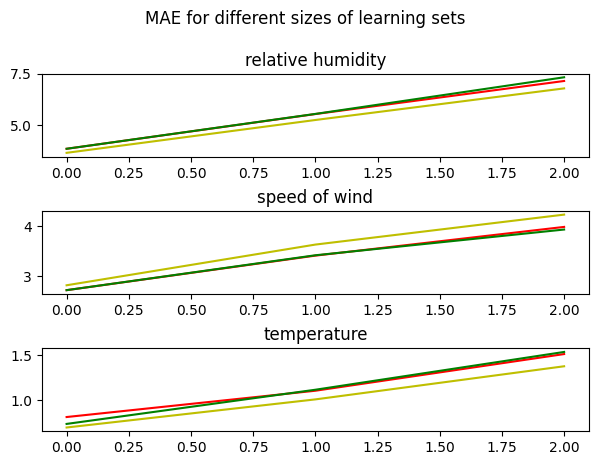

In [93]:
fig, axs = plt.subplots(3)
fig.suptitle('MAE for different sizes of learning sets')
fig.tight_layout(pad=1.8)
axs[0].plot(AllMAE_humid_6[0],'r')
axs[0].plot(AllMAE_humid_6[1],'g')
axs[0].plot(AllMAE_humid_6[2],'y')
axs[0].set_title('relative humidity')

axs[1].plot(AllMAE_wind_6[0],'r')
axs[1].plot(AllMAE_wind_6[1],'g')
axs[1].plot(AllMAE_wind_6[2],'y')
axs[1].set_title('speed of wind')

axs[2].plot(AllMAE_temp_6[0],'r')
axs[2].plot(AllMAE_temp_6[1],'g')
axs[2].plot(AllMAE_temp_6[2],'y')
axs[2].set_title('temperature')

# axs[3].plot(actual[2][:])
# axs[3].set_title('temperature')